# Kampff lab - Ultra dense survey


Here a description of the dataset:
http://www.kampff-lab.org/ultra-dense-survey/

Here the official publication of this open dataset:
https://crcns.org/data-sets/methods/hdr-1/about-hdr-1

And a paper is being preparing here:
https://doi.org/10.1101/275818


## Introduction

This dataset explore optimal size and density of electrodes.

Here 255 extracellular electrodes (5 x 5 μm and spacing of 1 μm) 

## Download

Dataset must downloaded locally and manually from crcns or from the google drive in **"workdir"** path.


## The PRB file
tridesclous need a PRB file that describe the geometry of probe.

Create it by copy/paste or download it via github.

In [4]:
# suposing the datset is downloaded here
workdir = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/kampff/ultra dense/'
filename = workdir + 'T2/amplifier2017-02-08T21_38_55.bin'


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import tridesclous as tdc
from tridesclous import DataIO, CatalogueConstructor, Peeler
import os, shutil

## create a DataIO (and remove if already exists)

In [4]:
dirname = workdir + 'tdc_amplifier2017-02-02T17_18_46'

if os.path.exists(dirname):
    #remove is already exists
    shutil.rmtree(dirname)
    
dataio = DataIO(dirname=dirname)

# feed DataIO with one file
dataio.set_data_source(type='RawData', filenames=[filename], 
                    sample_rate=20000., dtype='int16', total_channel=256,
                    bit_to_microVolt=0.195)
print(dataio)

# set the probe file
dataio.set_probe_file('kampff_ultra_dense_256.prb')

DataIO <id: 139865362390880> 
  workdir: /media/samuel/dataspikesorting/DataSpikeSortingHD2/kampff/ultra dense/tdc_amplifier2017-02-02T17_18_46
  sample_rate: 20000.0
  total_channel: 256
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch252 ch253 ch254 ch255]
  nb_segment: 1
  length: 32840000
  durations: 1642.0 s.


# CatalogueConstructor

Run all chain in one shot.

In [5]:
cc = CatalogueConstructor(dataio=dataio, chan_grp=0)

fullchain_kargs = {
    'duration' : 10,
    'preprocessor' : {
        'highpass_freq' : 400.,
        'lowpass_freq' : 5000.,
        'smooth_size' : 0,
        'chunksize' : 1024,
        'lostfront_chunksize' : 128,
        'signalpreprocessor_engine' : 'numpy',
    },
    'peak_detector' : {
        'peakdetector_engine' : 'numpy',
        'peak_sign' : '-',
        'relative_threshold' : 5.,
        'peak_span' : 0.0002,
    },
    'noise_snippet' : {
        'nb_snippet' : 300,
    },
    'extract_waveforms' : {
        'n_left' : -20,
        'n_right' : 30,
        'mode' : 'rand',
        'nb_max' : 20000,
        'align_waveform' : False,
    },
    'clean_waveforms' : {
        'alien_value_threshold' : 100.,
    },
  }
feat_method = 'peak_max'
feat_kargs = {}
clust_method = 'sawchaincut'
clust_kargs = {}
      
tdc.apply_all_catalogue_steps(cc, fullchain_kargs, 
        feat_method, feat_kargs,clust_method, clust_kargs)


estimate_signals_noise 13.549947649997193
run_signalprocessor 10.526179895998212
compute_all_centroid 1.8958099670016964
extract_some_waveforms 2.222353832999943
compute_all_centroid 1.8828996259981068
clean_waveforms 2.059075879999
extract_some_noise 0.06732735599871376
project 0.12861718400017708
compute_all_centroid 0.3774508770002285
order_clusters waveforms_rms
find_clusters 5.957443977000366


## See clusters

we have 2 cluster in teh catalogue

In [7]:
print(cc)

CatalogueConstructor
  chan_grp 0 - ch0 ch1 ch2 ... ch254 ch255
  nb_peak_by_segment: 1445
  some_waveforms.shape: (1445, 50, 255)
  some_features.shape: (1445, 255)
  cluster_labels [-1  0  1]



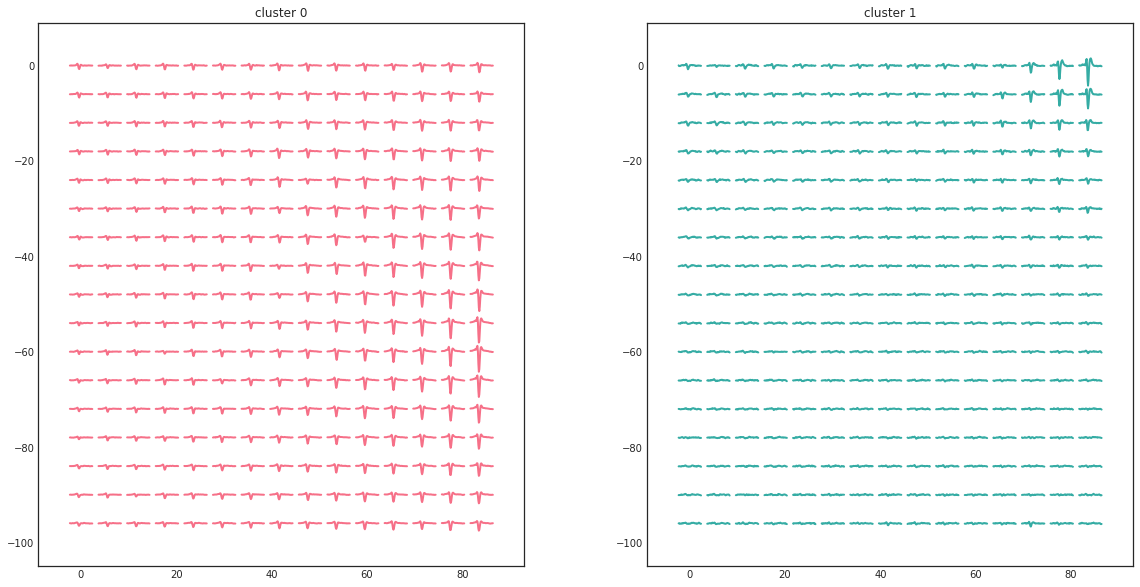

In [8]:
labels = cc.positive_cluster_labels
fig, axs = plt.subplots(ncols=len(labels))
for i, label in enumerate(labels):
    tdc.plot_centroids(cc, labels=[label,], ax=axs[i], 
                       flip_bottom_up=True, show_channels=False,
                       show_ticks=True)
    axs[i].set_title('cluster {}'.format(label))


Cluster 0
Max on channel (abs): 81
Max on channel (local to group): 80
Peak amplitude MAD: -11.64999771118164
Peak amplitude (µV): -114.22015036741635




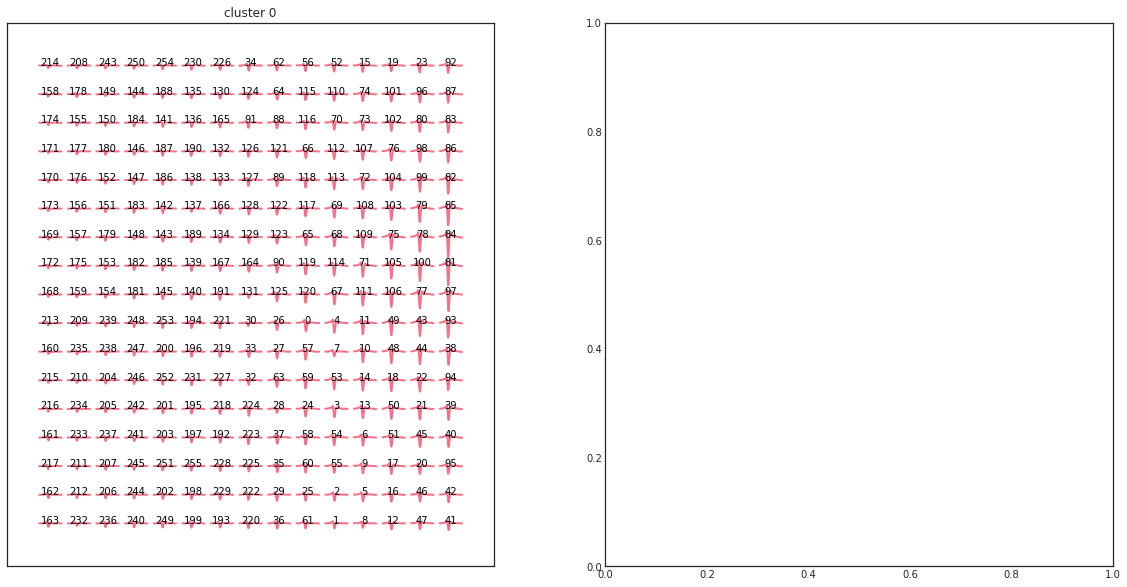

In [6]:
dirname = workdir + 'tdc_amplifier2017-02-02T17_18_46'
dataio = DataIO(dirname=dirname)
cc = CatalogueConstructor(dataio=dataio, chan_grp=0)

tdc.summary_clusters(cc, label=0)


Cluster 1
Max on channel (abs): 41
Max on channel (local to group): 40
Peak amplitude MAD: -7.862976551055908
Peak amplitude (µV): -79.64002215058022




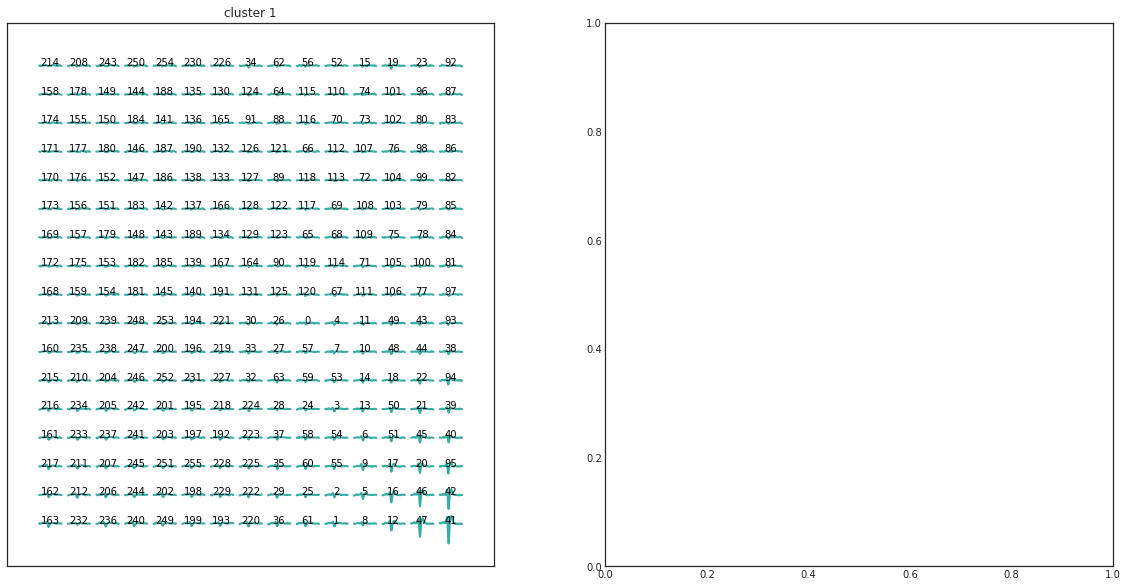

In [7]:
tdc.summary_clusters(cc, label=1)